Paper: Using random testing in a feedback-control loop to manage a safe exit from the COVID-19 lockdown
Markus Mu ̈ller,

source: https://www.medrxiv.org/content/10.1101/2020.04.09.20059360v2


### Overview:
A baseline model is taken from the paper above to provide a simulation of the infection level and growth rate for a given number of random tests administered equally across the whole population. The model incorporates an infection rate boundary that will trigger an internvetion (an easing intervention will increase the infection and growth rate, and a restricting intervention will reduce them)


My goal is to revise the model to manage various numbers of tests and levels of intervention across three distinct age groups in the population, in order to model the infection rate for each group under different circumstances

#### I make these revisions in three steps :
1. Intervention goes from binary to continuous (intervention_intensity parameter for each group can be between 0 - 1)

2. Severity-of-testing parameter to divide the number of tests for the population into each age group (testing_severity across all groups sums to 1)

3. Caution parameter (changes the range between i_low and i_high for an intervention to be triggered)



In [214]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [215]:
# N(t): Cardinality of random sample of infected people on day t. 
# The number N(t) is obtained by sampling from a Gaussian distribution of mean i(t) r and standard deviation
# i(t)r and rounding the obtained real number to the next non-negative integer.
def get_N(t, i, r):
    import math
    mean = i[t]*r
    std  = mean**0.5
    return math.ceil(np.random.normal(loc=mean, scale=std))

In [216]:
def estimate_k_est(t_first, delta_t, N):
    if delta_t % 2 == 0:
        half = delta_t // 2
        N_1 = sum([N[t_first + m] for m in range(half)])
        N_2 = sum([N[t_first + half + m] for m in range(half)])
        if N_1*N_2 > 0:
            k_est = 2/delta_t * math.log(N_2 / N_1)
            delta_k_est = 2/delta_t * (1/N_1 + 1/N_2)**0.5
        else:
            k_est, delta_k_est = (0, 1000)
    else:
        sum_to = (delta_t - 1)//2
        N_1 = sum([N[t_first + m] for m in range(sum_to)])
        N_m = N[t_first + sum_to]
        N_2 = sum([N[t_first + (delta_t + 1)//2 + m] for m in range(sum_to)])
        N_1_dash = N_1 + N_m
        N_2_dash = N_2 + N_m
        
        if N_1 * N_2 > 0:
            k_est = (2/(delta_t - 1)) * math.log(N_2/N_1)
            delta_k_est = (2/(delta_t - 1))*(N_2_dash/(N_2**2) + N_1_dash/(N_1**2) + N_m * (1/N_2 - 1/N_1)**2)**0.5
        else:
            k_est, delta_k_est = (0, 1000)
    return k_est, delta_k_est

# 1. Add Continuous Intervention Intensity Parameter
When an intervention is triggered beacuse the 'infection factor' is above/below i_high/ i_low, a restricting/relaxing 'internvetion' occurs. 

An intervention effectively decreases/increases the growth rate in the next day (t+1)

Previously, any intervention = 1, 

Now, intervention_level for elderly = 0.6, adult = 0.2, child = 0.2

Note: These numbers are only relative to each other. They are not representative of a certain type of intervention and do not include information regarding the number of people who are in lockdown etc. (e.g. 0.6 only means 3x more strict than 0.2)


In [217]:
def run_model(
    # number of days to run for
    t_until,
    r,
    intervention_intensity = 1,
    i_low = 0.2,
    i_high = 3,
    i_star = 0.0007, # (safe reboot with instataneous growth rate known with random testing - if i< ic/4)
    #i_star = 0.0014, # ic/20 (reboot only possible if i< ic/20)
    
    k_min = 0.005,
    k_low = -0.1,
    k_high = 0.23,
    T_min = 3,
    b = 0.5,
    alpha = 2,
    # variable arguments
    n_int = 1,
    C_h = 1,
    C_e = 0,
    k_init = 0.1,
    feature = None
):
    t_first = 0
    k = [k_init, k_init]
    i = [i_star]
    N = [get_N(0, i, r)]
    C_e = [C_e]
    C_h = [C_h]
    interventions = [0]
    
    #caution = age_group_caution_parameter['elderly']

    for t in range(1, t_until):
        intervention = False
        i.append(i[t-1]*math.e**(k[t-1]))
        i_t_div_i_star = i[t] / i_star

        C_h.append(max(C_h[t-1], i_t_div_i_star))
        C_e.append(C_e[t-1] - k[t])
       
        N.append(get_N(t, i, r))

        minimal_time_to_wait_exceeded = t - t_first >= T_min
        
        # if infection factor * caution is lower than desired threshold so ease restrictions
        if i_t_div_i_star < i_low and minimal_time_to_wait_exceeded:
            x = np.random.uniform()
            k.append(k[t] + (1-intervention_intensity)*(x*k[0]))
            intervention = True
            
        
        # if infection factor * caution is higher than desired threshold so increase restrictions
        elif i_t_div_i_star > i_high and minimal_time_to_wait_exceeded:
            x = np.random.uniform()
            k.append(k[t] - (intervention_intensity)*((1+x)/(2 * k_high)))
            intervention = True
            
        elif i_low < i_t_div_i_star and i_t_div_i_star < i_high:
            delta_t = t - t_first + 1
            k_est, delta_k_est = estimate_k_est(t_first, delta_t, N)

            if abs(k_est) > k_min and (k_est > alpha*delta_k_est or k_est < -alpha*delta_k_est):
                # if it's growing or shrinkly quickly, intervene
                x = np.random.uniform(b, 1/b)
                k.append(k[t] - x * k_est)
                intervention = True
            else:
                k.append(k[t])
        else:
            k.append(k[t])
        
        if intervention:
            t_first = t + 1 # the intervention happens tomorrow
        interventions.append(1 if intervention else 0)
        
        # limit k to be in [k_low, k_high]
        k[t + 1] = min(k[t + 1], k_high)
        k[t + 1] = max(k[t + 1], k_low)
    k.pop()
    suffix = f'_{feature}' if feature else ''
     
    output_df = pd.DataFrame({
        f'k{suffix}': k,
        f'N{suffix}': N,
        f'i{suffix}': i,
        f'c_h{suffix}': C_h,
        f'c_e{suffix}': C_e,
        'intervention': interventions
    })
    
    return output_df

def plot(results, feature, kind):
    plt.xlabel('day since t=0')
    results[[feature]].plot(kind=kind, logy=True)
    


In [218]:
age_group_intervention_intensity = {}

#policy = middle
age_group_intervention_intensity['child'] = 1

##less intense policy
#relax increases k by 0.6 more (1+0.6 = 1.6)
#strict decreses k by 0.6 less (just take 0.6)
age_group_intervention_intensity['adult'] = 0.6 

##more intense policy
#relax increases l by (1 + 1.5 = 2.5)
#strict decreses k by 1.5 less (just take 1.5)
age_group_intervention_intensity['elderly'] = 1.5

# 2. Add Severity-of-testing Parameter
Proportion of the total number of test that you will allocate to each subgroup

"""
{
  'model_name': { params},
  'adult': { r: '', intervention}
}
"""

In [259]:
params = {
    'child': { 'r': 3333, 'intervention_intensity': 0.2 },
    'adult': { 'r': 3333, 'intervention_intensity': 0.2 },
    'elderly': { 'r': 3333, 'intervention_intensity': 0.6 }
}


def run_for_params(n_runs, t_until, params):
    all_groups = []
    for group in params.keys():
        dfs = []
        runs = 0
        while runs < n_runs:
            try:
                dfs.append(run_model(t_until, **params[group]))
                runs += 1
            except:
                continue
        results = sum(dfs) / n_runs
        results['model'] = group
        all_groups.append(results)
    results = pd.concat(all_groups)
    results['n_runs'] = n_runs
    results['t_until'] = t_until
    return results


In [260]:
multiple_runs_dfs = run_for_params(100, 100, params)

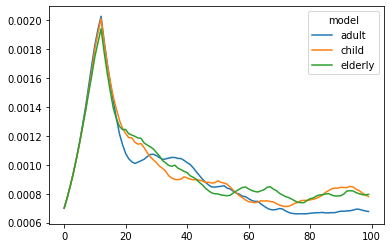

In [261]:
multiple_runs_dfs.pivot(columns='model', values='i').plot()


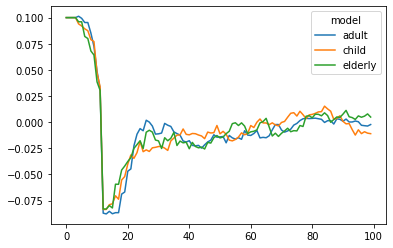

In [262]:
multiple_runs_dfs.pivot(columns='model', values='k').plot()


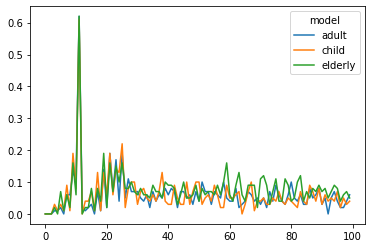

In [263]:
multiple_runs_dfs.pivot(columns='model', values='intervention').plot()


In [250]:
#looking at how much k changes when there is an intervention 
pct_change_k = pd.DataFrame(run_model(t_until = 100, intervention_intensity = age_group_intervention_intensity['child'], r=r_values['child']).k.pct_change())
pct_change_k[pct_change_k['k'] != 0]


,k
0,NaN
12,-2.000000
24,-1.078056


# 3. Add Caution Parameter
Although each subgroup already has an intervention intensity parameter and is allocated a different number of tests, the range between i_low and i_high when an intervention is triggered, is still the same. 

The caution parameter effectively increases or decreases the range of between i_low and i_high depending on the subgroup. For example, this allows for the adult subgroup to have a higher infection level before an restricting intervention is triggered, compared to the elderly subgroup, whose range will be much smaller

In [264]:
def run_model(
    # number of days to run for
    t_until,
    r,
    caution,
    intervention_intensity = 1,
    i_low = 0.2,
    i_high = 3,
    i_star = 0.0007, # (safe reboot with instataneous growth rate known with random testing - if i< ic/4)
    #i_star = 0.0014, # ic/20 (reboot only possible if i< ic/20)
    
    k_min = 0.005,
    k_low = -0.1,
    k_high = 0.23,
    T_min = 3,
    b = 0.5,
    alpha = 2,
    # variable arguments
    n_int = 1,
    C_h = 1,
    C_e = 0,
    k_init = 0.1,
    feature = None
):
    t_first = 0
    k = [k_init, k_init]
    i = [i_star]
    N = [get_N(0, i, r)]
    C_e = [C_e]
    C_h = [C_h]
    interventions = [0]
    
    #caution = age_group_caution_parameter['elderly']

    for t in range(1, t_until):
        intervention = False
        i.append(i[t-1]*math.e**(k[t-1]))
        i_t_div_i_star = i[t] / i_star

        C_h.append(max(C_h[t-1], i_t_div_i_star))
        C_e.append(C_e[t-1] - k[t])
       
        N.append(get_N(t, i, r))

        minimal_time_to_wait_exceeded = t - t_first >= T_min
        
        # if infection factor * caution is lower than desired threshold so ease restrictions
        if i_t_div_i_star * caution < i_low and minimal_time_to_wait_exceeded:
            x = np.random.uniform()
            k.append(k[t] + (1-intervention_intensity)*(x*k[0]))
            intervention = True
            
        
        # if infection factor * caution is higher than desired threshold so increase restrictions
        elif i_t_div_i_star * caution > i_high and minimal_time_to_wait_exceeded:
            x = np.random.uniform()
            k.append(k[t] - (intervention_intensity)*((1+x)/(2 * k_high)))
            intervention = True
            
        elif i_low < i_t_div_i_star and i_t_div_i_star < i_high:
            delta_t = t - t_first + 1
            k_est, delta_k_est = estimate_k_est(t_first, delta_t, N)

            if abs(k_est) > k_min and (k_est > alpha*delta_k_est or k_est < -alpha*delta_k_est):
                # if it's growing or shrinkly quickly, intervene
                x = np.random.uniform(b, 1/b)
                k.append(k[t] - x * k_est)
                intervention = True
            else:
                k.append(k[t])
        else:
            k.append(k[t])
        
        if intervention:
            t_first = t + 1 # the intervention happens tomorrow
        interventions.append(1 if intervention else 0)
        
        # limit k to be in [k_low, k_high]
        k[t + 1] = min(k[t + 1], k_high)
        k[t + 1] = max(k[t + 1], k_low)
    k.pop()
    suffix = f'_{feature}' if feature else ''
     
    output_df = pd.DataFrame({
        f'k{suffix}': k,
        f'N{suffix}': N,
        f'i{suffix}': i,
        f'c_h{suffix}': C_h,
        f'c_e{suffix}': C_e,
        'intervention': interventions
    })
    
    return output_df

def plot(results, feature, kind):
    plt.xlabel('day since t=0')
    results[[feature]].plot(kind=kind, logy=True)
    


In [277]:
def run_for_params(n_runs, t_until, params):
    all_groups = []
    for group in params.keys():
        dfs = []
        runs = 0
        while runs < n_runs:
            try:
                dfs.append(run_model(t_until, **params[group]))
                runs += 1
            except:
                continue
        results = sum(dfs) / n_runs
        results['model'] = group
        all_groups.append(results)
    results = pd.concat(all_groups)
    results['n_runs'] = n_runs
    results['t_until'] = t_until
    return results


In [278]:
#i_low = 0.2 and i_high = 3

#caution parameter is used by calculating:
#if i[t] * caution_parameter < i_low 
#if i[t] * caution_parameter < i_high
#The caution parameter effectively changes number that i_low, and i_high are for each group
age_group_caution_parameter = {}

#policy = middle (i_low = 0.2 and i_high = 3)
age_group_caution_parameter['child'] = 1

#policy = larger range for infection rate between i_low, i_high, before an intervention is triggered
#Infection level and can higher before restricting intervention, and does not need to go so low before relaxation
#(turns i_low = 0.3 and i_high = 5)
age_group_caution_parameter['adult'] = 0.6

#policy = smaller range that i can be between, before intervention is triggered by hitting i_low, i_high 
#(turns i_low = 0.13 and i_high = 2)
age_group_caution_parameter['elderly'] = 1.5

# Runs for different number of tests per age group

In [299]:
def plot_one(df, title, x_label, y_label, plot_parameter):
    results = df.pivot(columns='model', values=plot_parameter)
    ax = results.plot(figsize=(15, 5), 
                      title=title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)



In [308]:
#total tests = 10000
#adult = 50%
#child = 20%
#elderly = 30%
params_different_r_10000 = {
    'child': { 'r': 3000, 'intervention_intensity': 0.2 , 'caution': 1},
    'adult': { 'r': 5000, 'intervention_intensity': 0.2 , 'caution': 0.6},
    'elderly': { 'r': 2000, 'intervention_intensity': 0.6, 'caution': 1.5 }
}



#total tests = 30000
#adult = 50%
#child = 20%
#elderly = 30%
params_different_r_30000 = {
    'child': { 'r': 9000, 'intervention_intensity': 0.2 , 'caution': 1},
    'adult': { 'r': 15000, 'intervention_intensity': 0.2 , 'caution': 0.6},
    'elderly': { 'r': 6000, 'intervention_intensity': 0.6, 'caution': 1.5 }
}

In [ ]:
multiple_runs_dfs_r_10000 = run_for_params(100, 30, params_different_r_10000)
multiple_runs_dfs_r_30000 = run_for_params(100, 30, params_different_r_30000)


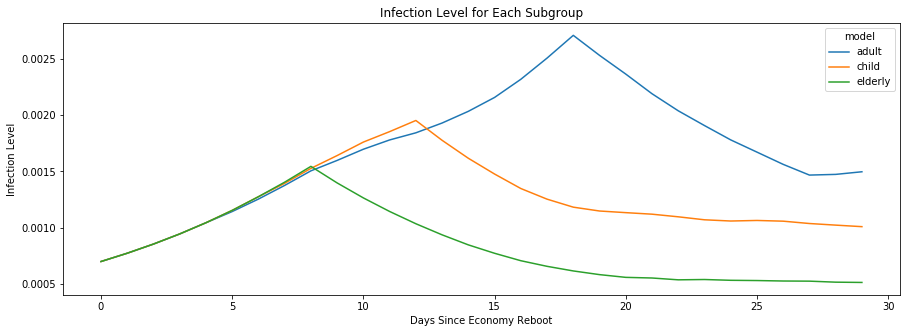

In [306]:
plot_one(multiple_runs_dfs_r_10000,
      title='Infection Level for Each Subgroup', 
      x_label = 'Days Since Economy Reboot', 
      y_label = 'Infection Level', 
         plot_parameter='i')



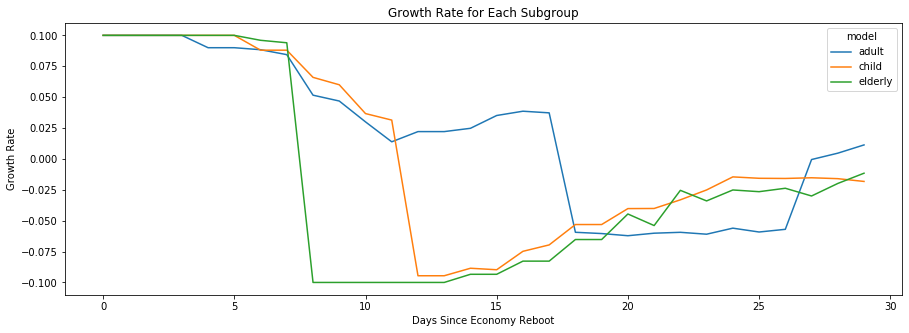

In [310]:
plot_one(multiple_runs_dfs_r_10000,
      title='Growth Rate for Each Subgroup', 
      x_label = 'Days Since Economy Reboot', 
      y_label = 'Growth Rate', 
         plot_parameter='k')


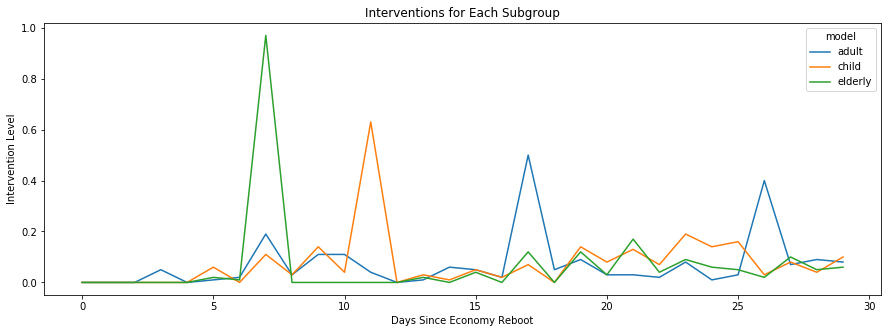

In [311]:
plot_one(multiple_runs_dfs_r_10000,
      title='Interventions for Each Subgroup', 
      x_label = 'Days Since Economy Reboot', 
      y_label = 'Intervention Level', 
         plot_parameter='intervention')


In [345]:
def plot_two(df1, df2, plot_parameter, title1, title2, commonXlabel, commonYlabel):
    #make results dfs from model runs
    results_10000 = df1.pivot(columns='model', values=plot_parameter)
    results_30000 = df2.pivot(columns='model', values=plot_parameter)
    
    # Create two subplots and unpack the output array immediately
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5), sharey=True)
    fig.text(0.5, 0.04, commonXlabel, ha='center')
    fig.text(0.04, 0.5, commonYlabel, va='center', rotation='vertical')
    
    #plot 1
    ax1.plot(results_10000['adult'], label='adult')
    ax1.plot(results_10000['child'], label='child')
    ax1.plot(results_10000['elderly'], label='elderly')
    ax1.legend()
    ax1.set_title(title1)

    #plot2
    ax2.plot(results_30000['adult'], label='adult')
    ax2.plot(results_30000['child'], label='child')
    ax2.plot(results_30000['elderly'], label='elderly')
    ax2.legend()
    ax2.set_title(title2)


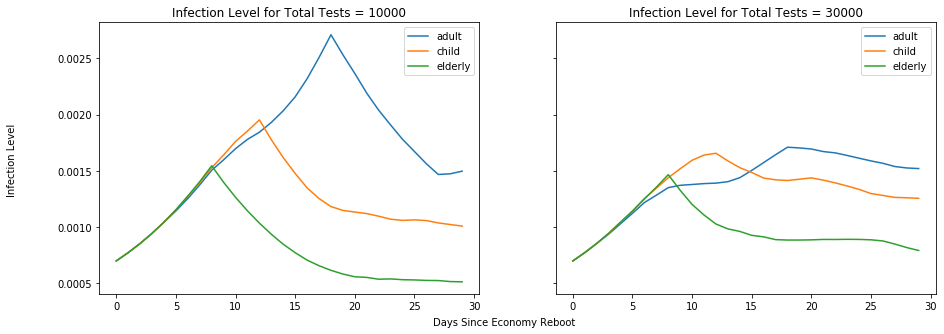

In [341]:
plot_two(df1 = multiple_runs_dfs_r_10000, 
         df2 = multiple_runs_dfs_r_30000, 
         plot_parameter = 'i',
         title1='Infection Level for Total Tests = 10000', 
         title2='Infection Level for Total Tests = 30000', 
        commonXlabel = 'Days Since Economy Reboot', 
        commonYlabel = 'Infection Level')

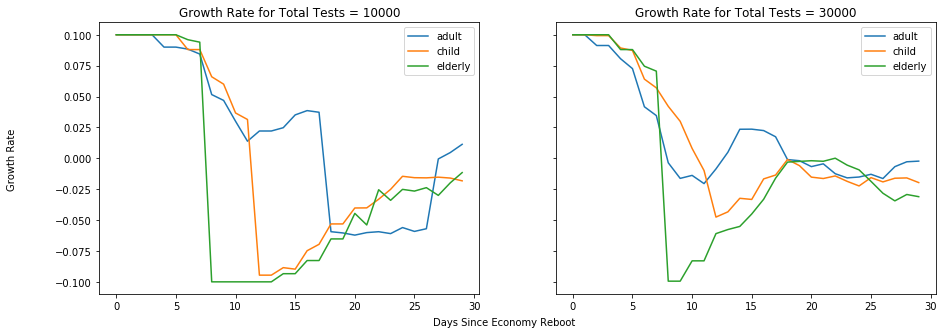

In [343]:
plot_two(df1 = multiple_runs_dfs_r_10000, 
         df2 = multiple_runs_dfs_r_30000, 
         plot_parameter = 'k', 
         title1='Growth Rate for Total Tests = 10000', 
         title2='Growth Rate for Total Tests = 30000', 
         commonXlabel = 'Days Since Economy Reboot', 
        commonYlabel = 'Growth Rate')


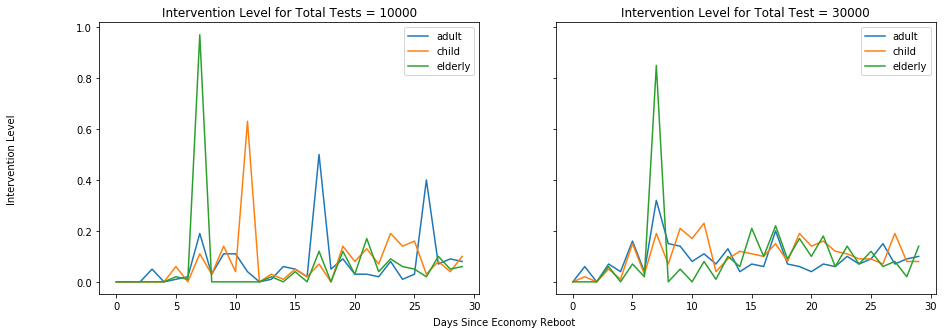

In [344]:
plot_two(df1 = multiple_runs_dfs_r_10000, 
         df2 = multiple_runs_dfs_r_30000, 
         plot_parameter = 'intervention', 
         title1='Intervention Level for Total Tests = 10000', 
         title2='Intervention Level for Total Test = 30000', 
        commonXlabel = 'Days Since Economy Reboot', 
        commonYlabel = 'Intervention Level')


# Turning i into probability

In [348]:

def probability_asymptomatic(df, model_group):
    df = multiple_runs_dfs_r[df['model']==model_group]
    df['probability'] = df['i']*10000 #multiply by total number of tests 
    df['probability'] = df['probability']/100 #divide by 100 to get probability

    return df
    


In [350]:
probability_df = probability_asymptomatic(df = multiple_runs_dfs_r_10000, model_group='child')
probability_df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,k,N,i,c_h,c_e,intervention,model,n_runs,t_until,probability
0,0.100000,6.48,0.000700,1.000000,0.000000,0.00,child,100,30,0.070000
1,0.100000,7.56,0.000774,1.105171,-0.100000,0.02,child,100,30,0.077362
2,0.099300,8.15,0.000855,1.221403,-0.199300,0.00,child,100,30,0.085498
3,0.099300,8.94,0.000945,1.350448,-0.298600,0.04,child,100,30,0.094450
4,0.091300,9.89,0.001044,1.493550,-0.389900,0.00,child,100,30,0.104394
5,0.091300,10.69,0.001146,1.646036,-0.481200,0.13,child,100,30,0.114603
6,0.066260,11.91,0.001260,1.815327,-0.547460,0.08,child,100,30,0.126034
7,0.050194,12.62,0.001356,1.978476,-0.597654,0.15,child,100,30,0.135610
8,0.031635,13.32,0.001439,2.135200,-0.629289,0.13,child,100,30,0.143874
9,0.013390,14.13,0.001504,2.277733,-0.642679,0.21,child,100,30,0.150448
